In [ ]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.0 MB/s eta 0:00:00


In [ ]:
# Cell 1: Imports and Environment Setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import tqdm
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Cell 2: Environment Definition
class DataCenterEnv(gym.Env):
    def __init__(self):
        super(DataCenterEnv, self).__init__()
        self.action_space = spaces.Discrete(3)  # Actions: Increase cooling, decrease cooling, keep the same

        # Observation space: [Temperature, Energy consumption, CPU utilization, GPU utilization, Network load]
        self.observation_space = spaces.Box(
            low=np.array([18, 0, 0, 0, 0]),
            high=np.array([40, 1, 1, 1, 1]),
            dtype=np.float32
        )

        self.state = None
        self.cooling_effect = 0.1
        self.time_step = 0
        self.reset()

    def reset(self):
        self.state = np.array([
            np.random.uniform(28.0, 32.0),  # Temperature
            np.random.uniform(0.4, 0.6),    # Energy consumption
            np.random.uniform(0.3, 0.5),    # CPU utilization
            np.random.uniform(0.2, 0.4),    # GPU utilization
            np.random.uniform(0.1, 0.3)     # Network load
        ])
        self.time_step = 0
        return self.state

    def step(self, action):
        temperature, energy_consumption, cpu_util, gpu_util, network_load = self.state

        # Apply action
        if action == 0:  # Increase cooling
            temperature -= self.cooling_effect
            energy_consumption += 0.05
        elif action == 1:  # Decrease cooling
            temperature += self.cooling_effect
            energy_consumption -= 0.05

        # Simulate workload changes
        cpu_util += np.random.uniform(-0.05, 0.05)
        gpu_util += np.random.uniform(-0.05, 0.05)
        network_load += np.random.uniform(-0.03, 0.03)

        # Keep values in bounds
        temperature = np.clip(temperature, 18, 40)
        energy_consumption = np.clip(energy_consumption, 0, 1)
        cpu_util = np.clip(cpu_util, 0, 1)
        gpu_util = np.clip(gpu_util, 0, 1)
        network_load = np.clip(network_load, 0, 1)

        # Simplified reward system (-1, 0, 1)
        if 22 <= temperature <= 28:  # Optimal range
            reward = 1
        elif 20 <= temperature <= 30:  # Acceptable range
            reward = 0
        else:  # Out of acceptable range
            reward = -1

        self.state = np.array([temperature, energy_consumption, cpu_util, gpu_util, network_load])
        self.time_step += 1
        done = self.time_step >= 200

        return self.state, reward, done, {}

    def render(self):
        return f'Temp: {self.state[0]:.1f}°C, Energy: {self.state[1]:.2f}, CPU: {self.state[2]:.2f}, GPU: {self.state[3]:.2f}, Net: {self.state[4]:.2f}'

# Test the environment
env = DataCenterEnv()
print("Initial state:", env.render())
state, reward, done, _ = env.step(0)
print("After cooling increase:", env.render(), f"Reward: {reward}")

Initial state: Temp: 30.4°C, Energy: 0.42, CPU: 0.33, GPU: 0.27, Net: 0.14
After cooling increase: Temp: 30.3°C, Energy: 0.47, CPU: 0.34, GPU: 0.28, Net: 0.11 Reward: -1


In [ ]:
# Cell 3: DQN Model Definition
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.value = nn.Linear(128, 1)
        self.advantage = nn.Linear(128, action_dim)

        # Xavier Initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.value.weight)
        nn.init.xavier_uniform_(self.advantage.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value(x)
        advantage = self.advantage(x)
        return value + (advantage - advantage.mean(dim=1, keepdim=True))

# Initialize model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = DuelingDQN(state_dim, action_dim).to(device)
print("Model initialized")

Model initialized


In [ ]:
# Cell 4: Training Functions
def select_action(state, epsilon, model, action_dim):
    if np.random.random() < epsilon:
        return np.random.randint(action_dim)
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = model(state)
    return q_values.argmax().item()

def plot_metrics(rewards, losses, window=20):
    plt.figure(figsize=(12, 4))
    plt.clf()  # Clear the current figure

    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.6)
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, linewidth=2)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Average Loss')

    plt.tight_layout()
    plt.pause(0.1)  # Non-blocking plot update
    plt.close()

In [ ]:
# Cell 5: Training Loop
def train_dqn(env, model, episodes=100, batch_size=32, max_steps=200):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    memory = deque(maxlen=5000)
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    gamma = 0.99

    all_rewards = []
    all_losses = []

    try:
        for episode in range(episodes):
            if episode % 5 == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            state = env.reset()
            total_reward = 0
            losses = []

            # Modified to use range(max_steps + 1) to include the last step
            with tqdm(total=max_steps, desc=f'Episode {episode+1}/{episodes}') as pbar:
                for step in range(max_steps):
                    action = select_action(state, epsilon, model, env.action_space.n)
                    next_state, reward, done, _ = env.step(action)

                    memory.append((state, action, reward, next_state, done))
                    total_reward += reward

                    if len(memory) >= batch_size:
                        batch = np.random.choice(len(memory), batch_size, replace=False)
                        batch_data = [memory[i] for i in batch]

                        states = np.array([data[0] for data in batch_data])
                        actions = np.array([data[1] for data in batch_data])
                        rewards = np.array([data[2] for data in batch_data])
                        next_states = np.array([data[3] for data in batch_data])
                        dones = np.array([data[4] for data in batch_data])

                        states = torch.FloatTensor(states).to(device)
                        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                        rewards = torch.FloatTensor(rewards).to(device)
                        next_states = torch.FloatTensor(next_states).to(device)
                        dones = torch.FloatTensor(dones).to(device)

                        current_q = model(states).gather(1, actions)
                        next_q = model(next_states).max(1)[0].detach()
                        target_q = rewards + gamma * next_q * (1 - dones)

                        loss = nn.MSELoss()(current_q.squeeze(), target_q)
                        losses.append(loss.item())

                        optimizer.zero_grad()
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                    state = next_state
                    pbar.set_postfix({
                        'Reward': f'{total_reward:.1f}',
                        'Epsilon': f'{epsilon:.2f}',
                        'State': env.render()
                    })
                    pbar.update(1)

                    if done:
                        # Fill the progress bar to 200 even if episode ends early
                        remaining_steps = max_steps - step - 1
                        if remaining_steps > 0:
                            pbar.update(remaining_steps)
                        break

            all_rewards.append(total_reward)
            if losses:
                all_losses.append(np.mean(losses))

            epsilon = max(epsilon_min, epsilon * epsilon_decay)

            print(f'Episode {episode+1}: Total Reward: {total_reward:.1f}, '
                  f'Average Reward: {np.mean(all_rewards[-100:]):.1f}, '
                  f'Epsilon: {epsilon:.3f}')

            if (episode + 1) % 20 == 0:
                plot_metrics(all_rewards, all_losses)

    except Exception as e:
        print(f"Training stopped due to error: {str(e)}")
        return all_rewards, all_losses

    return all_rewards, all_losses

# Separate batch processing function
def process_batch(memory, batch_size, model, optimizer, gamma, device):
    batch = np.random.choice(len(memory), batch_size, replace=False)
    batch_data = [memory[i] for i in batch]

    # Efficient batch processing
    states = torch.FloatTensor([data[0] for data in batch_data]).to(device)
    actions = torch.LongTensor([data[1] for data in batch_data]).unsqueeze(1).to(device)
    rewards = torch.FloatTensor([data[2] for data in batch_data]).to(device)
    next_states = torch.FloatTensor([data[3] for data in batch_data]).to(device)
    dones = torch.FloatTensor([data[4] for data in batch_data]).to(device)

    with torch.no_grad():
        next_q = model(next_states).max(1)[0]
        target_q = rewards + gamma * next_q * (1 - dones)

    current_q = model(states).gather(1, actions).squeeze()
    loss = nn.MSELoss()(current_q, target_q)

    optimizer.zero_grad()
    loss.backward()
    # Add gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    return loss.item()

Episode 1/100: 100%|██████████| 200/200 [00:00<00:00, 236.91it/s, Reward=-124.0, Epsilon=1.00, State=Temp: 30.5°C, Energy: 0.10, CPU: 0.29, GPU: 1.00, Net: 0.37]


Episode 1: Total Reward: -124.0, Average Reward: -124.0, Epsilon: 0.995


Episode 2/100: 100%|██████████| 200/200 [00:01<00:00, 198.94it/s, Reward=-194.0, Epsilon=0.99, State=Temp: 31.6°C, Energy: 0.45, CPU: 0.71, GPU: 0.33, Net: 0.01]


Episode 2: Total Reward: -194.0, Average Reward: -159.0, Epsilon: 0.990


Episode 3/100: 100%|██████████| 200/200 [00:00<00:00, 202.73it/s, Reward=-200.0, Epsilon=0.99, State=Temp: 30.0°C, Energy: 1.00, CPU: 0.66, GPU: 0.19, Net: 0.75]


Episode 3: Total Reward: -200.0, Average Reward: -172.7, Epsilon: 0.985


Episode 4/100: 100%|██████████| 200/200 [00:00<00:00, 205.31it/s, Reward=0.0, Epsilon=0.99, State=Temp: 28.8°C, Energy: 0.97, CPU: 0.32, GPU: 0.53, Net: 0.59]


Episode 4: Total Reward: 0.0, Average Reward: -129.5, Epsilon: 0.980


Episode 5/100: 100%|██████████| 200/200 [00:01<00:00, 183.38it/s, Reward=-125.0, Epsilon=0.98, State=Temp: 29.9°C, Energy: 0.50, CPU: 0.09, GPU: 0.81, Net: 0.00]


Episode 5: Total Reward: -125.0, Average Reward: -128.6, Epsilon: 0.975


Episode 6/100: 100%|██████████| 200/200 [00:01<00:00, 186.76it/s, Reward=154.0, Epsilon=0.98, State=Temp: 26.7°C, Energy: 0.60, CPU: 0.03, GPU: 0.06, Net: 0.22]


Episode 6: Total Reward: 154.0, Average Reward: -81.5, Epsilon: 0.970


Episode 7/100: 100%|██████████| 200/200 [00:01<00:00, 184.85it/s, Reward=-200.0, Epsilon=0.97, State=Temp: 32.4°C, Energy: 0.50, CPU: 1.00, GPU: 0.56, Net: 0.36]


Episode 7: Total Reward: -200.0, Average Reward: -98.4, Epsilon: 0.966


Episode 8/100: 100%|██████████| 200/200 [00:01<00:00, 182.05it/s, Reward=99.0, Epsilon=0.97, State=Temp: 26.9°C, Energy: 0.95, CPU: 0.89, GPU: 0.57, Net: 0.04]


Episode 8: Total Reward: 99.0, Average Reward: -73.8, Epsilon: 0.961


Episode 9/100: 100%|██████████| 200/200 [00:01<00:00, 186.02it/s, Reward=-178.0, Epsilon=0.96, State=Temp: 30.2°C, Energy: 0.70, CPU: 0.19, GPU: 0.09, Net: 0.17]


Episode 9: Total Reward: -178.0, Average Reward: -85.3, Epsilon: 0.956


Episode 10/100: 100%|██████████| 200/200 [00:01<00:00, 179.00it/s, Reward=-124.0, Epsilon=0.96, State=Temp: 30.8°C, Energy: 0.35, CPU: 0.21, GPU: 0.27, Net: 0.35]


Episode 10: Total Reward: -124.0, Average Reward: -89.2, Epsilon: 0.951


Episode 11/100: 100%|██████████| 200/200 [00:01<00:00, 179.67it/s, Reward=-122.0, Epsilon=0.95, State=Temp: 29.8°C, Energy: 0.80, CPU: 0.55, GPU: 0.01, Net: 0.20]


Episode 11: Total Reward: -122.0, Average Reward: -92.2, Epsilon: 0.946


Episode 12/100: 100%|██████████| 200/200 [00:01<00:00, 187.48it/s, Reward=-200.0, Epsilon=0.95, State=Temp: 32.2°C, Energy: 0.15, CPU: 0.74, GPU: 0.58, Net: 0.44]


Episode 12: Total Reward: -200.0, Average Reward: -101.2, Epsilon: 0.942


Episode 13/100: 100%|██████████| 200/200 [00:01<00:00, 175.83it/s, Reward=-173.0, Epsilon=0.94, State=Temp: 30.3°C, Energy: 0.65, CPU: 0.95, GPU: 0.80, Net: 0.54]


Episode 13: Total Reward: -173.0, Average Reward: -106.7, Epsilon: 0.937


Episode 14/100: 100%|██████████| 200/200 [00:01<00:00, 175.94it/s, Reward=142.0, Epsilon=0.94, State=Temp: 26.8°C, Energy: 0.90, CPU: 0.99, GPU: 0.44, Net: 0.32]


Episode 14: Total Reward: 142.0, Average Reward: -88.9, Epsilon: 0.932


Episode 15/100: 100%|██████████| 200/200 [00:01<00:00, 175.08it/s, Reward=68.0, Epsilon=0.93, State=Temp: 26.7°C, Energy: 0.90, CPU: 0.11, GPU: 0.62, Net: 0.18]


Episode 15: Total Reward: 68.0, Average Reward: -78.5, Epsilon: 0.928


Episode 16/100: 100%|██████████| 200/200 [00:01<00:00, 180.60it/s, Reward=102.0, Epsilon=0.93, State=Temp: 27.5°C, Energy: 0.85, CPU: 0.13, GPU: 0.63, Net: 0.10]


Episode 16: Total Reward: 102.0, Average Reward: -67.2, Epsilon: 0.923


Episode 17/100: 100%|██████████| 200/200 [00:01<00:00, 171.83it/s, Reward=-2.0, Epsilon=0.92, State=Temp: 29.3°C, Energy: 0.41, CPU: 0.59, GPU: 0.57, Net: 0.38]


Episode 17: Total Reward: -2.0, Average Reward: -63.4, Epsilon: 0.918


Episode 18/100: 100%|██████████| 200/200 [00:01<00:00, 170.48it/s, Reward=98.0, Epsilon=0.92, State=Temp: 27.2°C, Energy: 0.85, CPU: 0.14, GPU: 0.33, Net: 0.51]


Episode 18: Total Reward: 98.0, Average Reward: -54.4, Epsilon: 0.914


Episode 19/100: 100%|██████████| 200/200 [00:01<00:00, 169.12it/s, Reward=34.0, Epsilon=0.91, State=Temp: 28.4°C, Energy: 0.40, CPU: 0.62, GPU: 0.48, Net: 0.08]


Episode 19: Total Reward: 34.0, Average Reward: -49.7, Epsilon: 0.909


Episode 20/100: 100%|██████████| 200/200 [00:01<00:00, 171.49it/s, Reward=-188.0, Epsilon=0.91, State=Temp: 29.8°C, Energy: 1.00, CPU: 0.07, GPU: 0.24, Net: 0.30]


Episode 20: Total Reward: -188.0, Average Reward: -56.6, Epsilon: 0.905


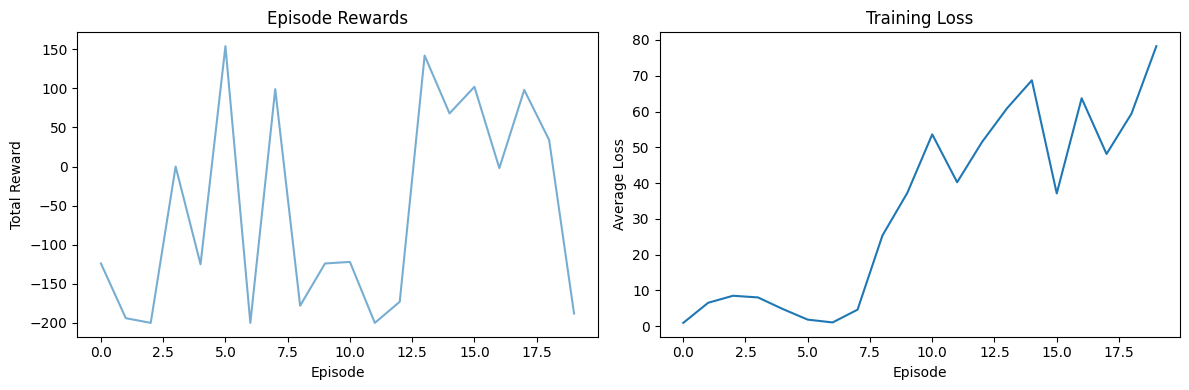

Episode 21/100: 100%|██████████| 200/200 [00:01<00:00, 172.77it/s, Reward=0.0, Epsilon=0.90, State=Temp: 29.3°C, Energy: 0.40, CPU: 0.04, GPU: 0.04, Net: 0.14]


Episode 21: Total Reward: 0.0, Average Reward: -54.0, Epsilon: 0.900


Episode 22/100: 100%|██████████| 200/200 [00:01<00:00, 174.56it/s, Reward=20.0, Epsilon=0.90, State=Temp: 27.8°C, Energy: 0.75, CPU: 0.42, GPU: 0.11, Net: 0.50]


Episode 22: Total Reward: 20.0, Average Reward: -50.6, Epsilon: 0.896


Episode 23/100: 100%|██████████| 200/200 [00:01<00:00, 172.43it/s, Reward=-69.0, Epsilon=0.90, State=Temp: 29.9°C, Energy: 0.60, CPU: 0.37, GPU: 0.48, Net: 0.26]


Episode 23: Total Reward: -69.0, Average Reward: -51.4, Epsilon: 0.891


Episode 24/100: 100%|██████████| 200/200 [00:01<00:00, 168.35it/s, Reward=80.0, Epsilon=0.89, State=Temp: 25.8°C, Energy: 1.00, CPU: 0.48, GPU: 0.46, Net: 0.52]


Episode 24: Total Reward: 80.0, Average Reward: -45.9, Epsilon: 0.887


Episode 25/100: 100%|██████████| 200/200 [00:01<00:00, 171.91it/s, Reward=114.0, Epsilon=0.89, State=Temp: 25.9°C, Energy: 1.00, CPU: 0.29, GPU: 0.05, Net: 0.16]


Episode 25: Total Reward: 114.0, Average Reward: -39.5, Epsilon: 0.882


Episode 26/100: 100%|██████████| 200/200 [00:01<00:00, 173.43it/s, Reward=34.0, Epsilon=0.88, State=Temp: 27.8°C, Energy: 0.85, CPU: 0.99, GPU: 0.02, Net: 0.06]


Episode 26: Total Reward: 34.0, Average Reward: -36.7, Epsilon: 0.878


Episode 27/100: 100%|██████████| 200/200 [00:01<00:00, 166.85it/s, Reward=195.0, Epsilon=0.88, State=Temp: 25.9°C, Energy: 0.95, CPU: 0.15, GPU: 0.84, Net: 0.14]


Episode 27: Total Reward: 195.0, Average Reward: -28.1, Epsilon: 0.873


Episode 28/100: 100%|██████████| 200/200 [00:01<00:00, 166.13it/s, Reward=-167.0, Epsilon=0.87, State=Temp: 29.5°C, Energy: 0.85, CPU: 0.03, GPU: 0.15, Net: 0.71]


Episode 28: Total Reward: -167.0, Average Reward: -33.1, Epsilon: 0.869


Episode 29/100: 100%|██████████| 200/200 [00:01<00:00, 171.19it/s, Reward=55.0, Epsilon=0.87, State=Temp: 26.4°C, Energy: 1.00, CPU: 0.33, GPU: 0.35, Net: 0.59]


Episode 29: Total Reward: 55.0, Average Reward: -30.0, Epsilon: 0.865


Episode 30/100: 100%|██████████| 200/200 [00:01<00:00, 163.19it/s, Reward=126.0, Epsilon=0.86, State=Temp: 27.1°C, Energy: 0.85, CPU: 0.58, GPU: 0.16, Net: 0.69]


Episode 30: Total Reward: 126.0, Average Reward: -24.8, Epsilon: 0.860


Episode 31/100: 100%|██████████| 200/200 [00:01<00:00, 164.31it/s, Reward=91.0, Epsilon=0.86, State=Temp: 27.1°C, Energy: 0.90, CPU: 0.58, GPU: 0.15, Net: 0.10]


Episode 31: Total Reward: 91.0, Average Reward: -21.1, Epsilon: 0.856


Episode 32/100: 100%|██████████| 200/200 [00:01<00:00, 161.69it/s, Reward=-37.0, Epsilon=0.86, State=Temp: 27.0°C, Energy: 1.00, CPU: 0.59, GPU: 0.43, Net: 0.72]


Episode 32: Total Reward: -37.0, Average Reward: -21.6, Epsilon: 0.852


Episode 33/100: 100%|██████████| 200/200 [00:01<00:00, 165.76it/s, Reward=196.0, Epsilon=0.85, State=Temp: 24.6°C, Energy: 0.85, CPU: 0.76, GPU: 0.31, Net: 0.25]


Episode 33: Total Reward: 196.0, Average Reward: -15.0, Epsilon: 0.848


Episode 34/100: 100%|██████████| 200/200 [00:01<00:00, 168.84it/s, Reward=76.0, Epsilon=0.85, State=Temp: 27.7°C, Energy: 0.95, CPU: 0.28, GPU: 0.99, Net: 0.35]


Episode 34: Total Reward: 76.0, Average Reward: -12.3, Epsilon: 0.843


Episode 35/100: 100%|██████████| 200/200 [00:01<00:00, 161.19it/s, Reward=-78.0, Epsilon=0.84, State=Temp: 28.7°C, Energy: 0.75, CPU: 0.67, GPU: 0.14, Net: 0.19]


Episode 35: Total Reward: -78.0, Average Reward: -14.2, Epsilon: 0.839


Episode 36/100: 100%|██████████| 200/200 [00:01<00:00, 166.98it/s, Reward=-104.0, Epsilon=0.84, State=Temp: 28.1°C, Energy: 0.85, CPU: 0.48, GPU: 0.07, Net: 0.51]


Episode 36: Total Reward: -104.0, Average Reward: -16.7, Epsilon: 0.835


Episode 37/100: 100%|██████████| 200/200 [00:01<00:00, 160.25it/s, Reward=-123.0, Epsilon=0.83, State=Temp: 28.1°C, Energy: 0.95, CPU: 0.02, GPU: 0.28, Net: 0.49]


Episode 37: Total Reward: -123.0, Average Reward: -19.6, Epsilon: 0.831


Episode 38/100: 100%|██████████| 200/200 [00:01<00:00, 160.29it/s, Reward=155.0, Epsilon=0.83, State=Temp: 25.6°C, Energy: 0.90, CPU: 0.08, GPU: 0.11, Net: 0.02]


Episode 38: Total Reward: 155.0, Average Reward: -15.0, Epsilon: 0.827


Episode 39/100: 100%|██████████| 200/200 [00:01<00:00, 161.41it/s, Reward=-100.0, Epsilon=0.83, State=Temp: 28.3°C, Energy: 0.90, CPU: 0.17, GPU: 0.57, Net: 0.22]


Episode 39: Total Reward: -100.0, Average Reward: -17.2, Epsilon: 0.822


Episode 40/100: 100%|██████████| 200/200 [00:01<00:00, 160.73it/s, Reward=157.0, Epsilon=0.82, State=Temp: 23.5°C, Energy: 1.00, CPU: 0.08, GPU: 0.34, Net: 0.10]


Episode 40: Total Reward: 157.0, Average Reward: -12.8, Epsilon: 0.818


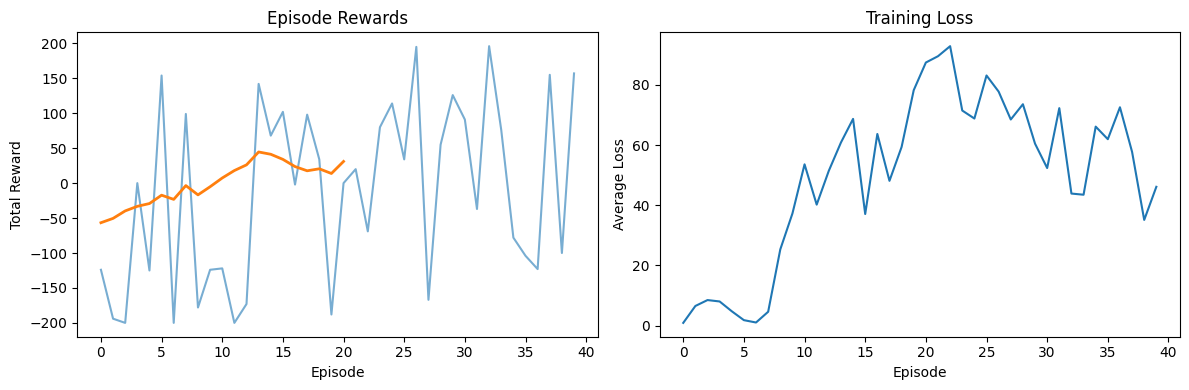

Episode 41/100: 100%|██████████| 200/200 [00:01<00:00, 155.80it/s, Reward=37.0, Epsilon=0.82, State=Temp: 27.1°C, Energy: 0.95, CPU: 0.66, GPU: 1.00, Net: 0.49]


Episode 41: Total Reward: 37.0, Average Reward: -11.6, Epsilon: 0.814


Episode 42/100: 100%|██████████| 200/200 [00:01<00:00, 156.31it/s, Reward=158.0, Epsilon=0.81, State=Temp: 26.2°C, Energy: 0.95, CPU: 0.36, GPU: 0.63, Net: 0.12]


Episode 42: Total Reward: 158.0, Average Reward: -7.5, Epsilon: 0.810


Episode 43/100: 100%|██████████| 200/200 [00:01<00:00, 155.46it/s, Reward=-41.0, Epsilon=0.81, State=Temp: 27.4°C, Energy: 1.00, CPU: 1.00, GPU: 0.16, Net: 0.22]


Episode 43: Total Reward: -41.0, Average Reward: -8.3, Epsilon: 0.806


Episode 44/100: 100%|██████████| 200/200 [00:01<00:00, 162.03it/s, Reward=43.0, Epsilon=0.81, State=Temp: 27.4°C, Energy: 1.00, CPU: 0.12, GPU: 0.04, Net: 0.48]


Episode 44: Total Reward: 43.0, Average Reward: -7.2, Epsilon: 0.802


Episode 45/100: 100%|██████████| 200/200 [00:01<00:00, 160.71it/s, Reward=-85.0, Epsilon=0.80, State=Temp: 28.4°C, Energy: 0.85, CPU: 0.05, GPU: 0.83, Net: 0.12]


Episode 45: Total Reward: -85.0, Average Reward: -8.9, Epsilon: 0.798


Episode 46/100: 100%|██████████| 200/200 [00:01<00:00, 161.16it/s, Reward=10.0, Epsilon=0.80, State=Temp: 28.2°C, Energy: 0.80, CPU: 0.60, GPU: 0.67, Net: 0.42]


Episode 46: Total Reward: 10.0, Average Reward: -8.5, Epsilon: 0.794


Episode 47/100: 100%|██████████| 200/200 [00:01<00:00, 149.61it/s, Reward=-30.0, Epsilon=0.79, State=Temp: 26.5°C, Energy: 1.00, CPU: 0.48, GPU: 0.19, Net: 0.23]


Episode 47: Total Reward: -30.0, Average Reward: -8.9, Epsilon: 0.790


Episode 48/100: 100%|██████████| 200/200 [00:01<00:00, 153.74it/s, Reward=161.0, Epsilon=0.79, State=Temp: 25.6°C, Energy: 0.65, CPU: 0.69, GPU: 0.44, Net: 0.25]


Episode 48: Total Reward: 161.0, Average Reward: -5.4, Epsilon: 0.786


Episode 49/100: 100%|██████████| 200/200 [00:01<00:00, 160.89it/s, Reward=-32.0, Epsilon=0.79, State=Temp: 27.0°C, Energy: 1.00, CPU: 0.46, GPU: 0.70, Net: 0.36]


Episode 49: Total Reward: -32.0, Average Reward: -5.9, Epsilon: 0.782


Episode 50/100: 100%|██████████| 200/200 [00:01<00:00, 157.06it/s, Reward=-115.0, Epsilon=0.78, State=Temp: 28.9°C, Energy: 0.98, CPU: 0.49, GPU: 0.26, Net: 0.11]


Episode 50: Total Reward: -115.0, Average Reward: -8.1, Epsilon: 0.778


Episode 51/100: 100%|██████████| 200/200 [00:01<00:00, 153.54it/s, Reward=79.0, Epsilon=0.78, State=Temp: 26.1°C, Energy: 0.95, CPU: 0.59, GPU: 0.15, Net: 0.26]


Episode 51: Total Reward: 79.0, Average Reward: -6.4, Epsilon: 0.774


Episode 52/100: 100%|██████████| 200/200 [00:01<00:00, 157.30it/s, Reward=188.0, Epsilon=0.77, State=Temp: 24.1°C, Energy: 0.90, CPU: 0.70, GPU: 0.79, Net: 0.27]


Episode 52: Total Reward: 188.0, Average Reward: -2.7, Epsilon: 0.771


Episode 53/100: 100%|██████████| 200/200 [00:01<00:00, 156.75it/s, Reward=15.0, Epsilon=0.77, State=Temp: 26.0°C, Energy: 0.95, CPU: 0.66, GPU: 0.97, Net: 0.21]


Episode 53: Total Reward: 15.0, Average Reward: -2.3, Epsilon: 0.767


Episode 54/100: 100%|██████████| 200/200 [00:01<00:00, 154.51it/s, Reward=8.0, Epsilon=0.77, State=Temp: 26.7°C, Energy: 1.00, CPU: 0.17, GPU: 0.87, Net: 0.09]


Episode 54: Total Reward: 8.0, Average Reward: -2.1, Epsilon: 0.763


Episode 55/100: 100%|██████████| 200/200 [00:01<00:00, 149.78it/s, Reward=-125.0, Epsilon=0.76, State=Temp: 28.7°C, Energy: 0.95, CPU: 0.32, GPU: 0.14, Net: 0.42]


Episode 55: Total Reward: -125.0, Average Reward: -4.4, Epsilon: 0.759


Episode 56/100: 100%|██████████| 200/200 [00:01<00:00, 148.49it/s, Reward=2.0, Epsilon=0.76, State=Temp: 26.8°C, Energy: 1.00, CPU: 0.49, GPU: 0.31, Net: 0.17]


Episode 56: Total Reward: 2.0, Average Reward: -4.3, Epsilon: 0.755


Episode 57/100: 100%|██████████| 200/200 [00:01<00:00, 153.82it/s, Reward=160.0, Epsilon=0.76, State=Temp: 23.9°C, Energy: 1.00, CPU: 0.55, GPU: 0.43, Net: 0.12]


Episode 57: Total Reward: 160.0, Average Reward: -1.4, Epsilon: 0.751


Episode 58/100: 100%|██████████| 200/200 [00:01<00:00, 156.75it/s, Reward=185.0, Epsilon=0.75, State=Temp: 25.9°C, Energy: 1.00, CPU: 0.62, GPU: 0.01, Net: 0.49]


Episode 58: Total Reward: 185.0, Average Reward: 1.8, Epsilon: 0.748


Episode 59/100: 100%|██████████| 200/200 [00:01<00:00, 151.82it/s, Reward=38.0, Epsilon=0.75, State=Temp: 27.6°C, Energy: 0.90, CPU: 0.08, GPU: 0.00, Net: 0.50]


Episode 59: Total Reward: 38.0, Average Reward: 2.4, Epsilon: 0.744


Episode 60/100: 100%|██████████| 200/200 [00:01<00:00, 158.25it/s, Reward=-39.0, Epsilon=0.74, State=Temp: 26.6°C, Energy: 1.00, CPU: 0.11, GPU: 0.24, Net: 0.09]


Episode 60: Total Reward: -39.0, Average Reward: 1.8, Epsilon: 0.740


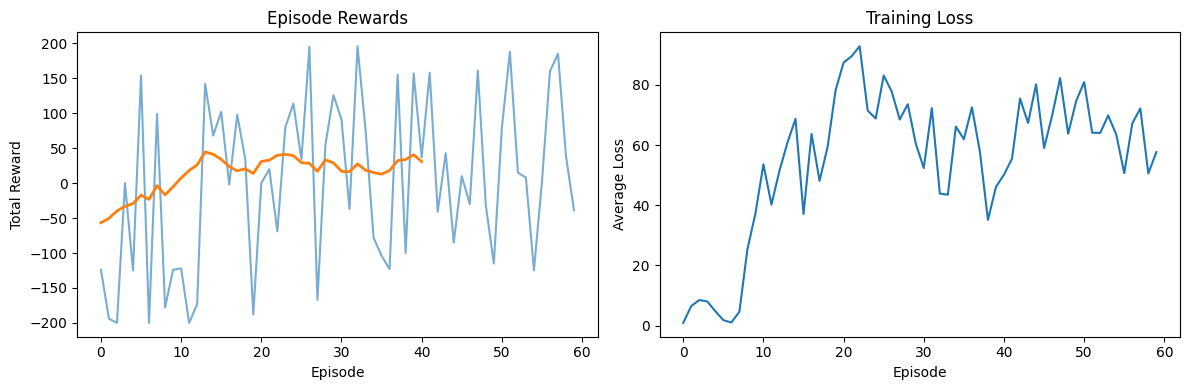

Episode 61/100: 100%|██████████| 200/200 [00:01<00:00, 151.72it/s, Reward=120.0, Epsilon=0.74, State=Temp: 25.3°C, Energy: 0.80, CPU: 0.00, GPU: 0.29, Net: 0.16]


Episode 61: Total Reward: 120.0, Average Reward: 3.7, Epsilon: 0.737


Episode 62/100: 100%|██████████| 200/200 [00:01<00:00, 146.65it/s, Reward=127.0, Epsilon=0.74, State=Temp: 23.9°C, Energy: 1.00, CPU: 0.34, GPU: 0.17, Net: 0.41]


Episode 62: Total Reward: 127.0, Average Reward: 5.7, Epsilon: 0.733


Episode 63/100: 100%|██████████| 200/200 [00:01<00:00, 148.35it/s, Reward=22.0, Epsilon=0.73, State=Temp: 26.9°C, Energy: 0.95, CPU: 0.25, GPU: 0.00, Net: 0.07]


Episode 63: Total Reward: 22.0, Average Reward: 5.9, Epsilon: 0.729


Episode 64/100: 100%|██████████| 200/200 [00:01<00:00, 142.85it/s, Reward=200.0, Epsilon=0.73, State=Temp: 24.5°C, Energy: 1.00, CPU: 0.89, GPU: 0.05, Net: 0.55]


Episode 64: Total Reward: 200.0, Average Reward: 9.0, Epsilon: 0.726


Episode 65/100: 100%|██████████| 200/200 [00:01<00:00, 145.73it/s, Reward=70.0, Epsilon=0.73, State=Temp: 24.5°C, Energy: 0.90, CPU: 0.04, GPU: 0.40, Net: 0.64]


Episode 65: Total Reward: 70.0, Average Reward: 9.9, Epsilon: 0.722


Episode 66/100: 100%|██████████| 200/200 [00:01<00:00, 152.92it/s, Reward=180.0, Epsilon=0.72, State=Temp: 25.2°C, Energy: 1.00, CPU: 0.07, GPU: 0.68, Net: 0.56]


Episode 66: Total Reward: 180.0, Average Reward: 12.5, Epsilon: 0.718


Episode 67/100: 100%|██████████| 200/200 [00:01<00:00, 146.07it/s, Reward=188.0, Epsilon=0.72, State=Temp: 23.8°C, Energy: 0.80, CPU: 0.60, GPU: 0.35, Net: 0.00]


Episode 67: Total Reward: 188.0, Average Reward: 15.1, Epsilon: 0.715


Episode 68/100: 100%|██████████| 200/200 [00:01<00:00, 145.32it/s, Reward=149.0, Epsilon=0.71, State=Temp: 24.8°C, Energy: 0.95, CPU: 0.07, GPU: 0.18, Net: 0.13]


Episode 68: Total Reward: 149.0, Average Reward: 17.1, Epsilon: 0.711


Episode 69/100: 100%|██████████| 200/200 [00:01<00:00, 151.76it/s, Reward=-6.0, Epsilon=0.71, State=Temp: 26.6°C, Energy: 1.00, CPU: 0.33, GPU: 0.25, Net: 0.09]


Episode 69: Total Reward: -6.0, Average Reward: 16.7, Epsilon: 0.708


Episode 70/100: 100%|██████████| 200/200 [00:01<00:00, 147.93it/s, Reward=176.0, Epsilon=0.71, State=Temp: 23.8°C, Energy: 0.95, CPU: 0.13, GPU: 0.04, Net: 0.15]


Episode 70: Total Reward: 176.0, Average Reward: 19.0, Epsilon: 0.704


Episode 71/100: 100%|██████████| 200/200 [00:01<00:00, 149.02it/s, Reward=197.0, Epsilon=0.70, State=Temp: 24.4°C, Energy: 0.95, CPU: 0.86, GPU: 0.17, Net: 0.11]


Episode 71: Total Reward: 197.0, Average Reward: 21.5, Epsilon: 0.701


Episode 72/100: 100%|██████████| 200/200 [00:01<00:00, 149.01it/s, Reward=131.0, Epsilon=0.70, State=Temp: 24.0°C, Energy: 0.95, CPU: 1.00, GPU: 0.64, Net: 0.44]


Episode 72: Total Reward: 131.0, Average Reward: 23.0, Epsilon: 0.697


Episode 73/100: 100%|██████████| 200/200 [00:01<00:00, 144.28it/s, Reward=200.0, Epsilon=0.70, State=Temp: 23.6°C, Energy: 1.00, CPU: 0.28, GPU: 0.96, Net: 0.06]


Episode 73: Total Reward: 200.0, Average Reward: 25.5, Epsilon: 0.694


Episode 74/100: 100%|██████████| 200/200 [00:01<00:00, 142.35it/s, Reward=-11.0, Epsilon=0.69, State=Temp: 26.6°C, Energy: 1.00, CPU: 0.17, GPU: 0.85, Net: 0.25]


Episode 74: Total Reward: -11.0, Average Reward: 25.0, Epsilon: 0.690


Episode 75/100: 100%|██████████| 200/200 [00:01<00:00, 137.02it/s, Reward=179.0, Epsilon=0.69, State=Temp: 25.7°C, Energy: 1.00, CPU: 0.41, GPU: 0.06, Net: 0.33]


Episode 75: Total Reward: 179.0, Average Reward: 27.0, Epsilon: 0.687


Episode 76/100: 100%|██████████| 200/200 [00:01<00:00, 140.63it/s, Reward=188.0, Epsilon=0.69, State=Temp: 25.2°C, Energy: 1.00, CPU: 0.49, GPU: 0.79, Net: 0.30]


Episode 76: Total Reward: 188.0, Average Reward: 29.1, Epsilon: 0.683


Episode 77/100: 100%|██████████| 200/200 [00:01<00:00, 144.63it/s, Reward=66.0, Epsilon=0.68, State=Temp: 26.0°C, Energy: 0.95, CPU: 0.75, GPU: 0.44, Net: 0.60]


Episode 77: Total Reward: 66.0, Average Reward: 29.6, Epsilon: 0.680


Episode 78/100: 100%|██████████| 200/200 [00:01<00:00, 147.48it/s, Reward=69.0, Epsilon=0.68, State=Temp: 26.7°C, Energy: 0.85, CPU: 0.59, GPU: 0.13, Net: 0.02]


Episode 78: Total Reward: 69.0, Average Reward: 30.1, Epsilon: 0.676


Episode 79/100: 100%|██████████| 200/200 [00:01<00:00, 145.72it/s, Reward=143.0, Epsilon=0.68, State=Temp: 24.7°C, Energy: 0.95, CPU: 0.15, GPU: 0.42, Net: 0.42]


Episode 79: Total Reward: 143.0, Average Reward: 31.6, Epsilon: 0.673


Episode 80/100: 100%|██████████| 200/200 [00:01<00:00, 150.31it/s, Reward=-12.0, Epsilon=0.67, State=Temp: 26.5°C, Energy: 1.00, CPU: 0.75, GPU: 0.14, Net: 0.45]


Episode 80: Total Reward: -12.0, Average Reward: 31.0, Epsilon: 0.670


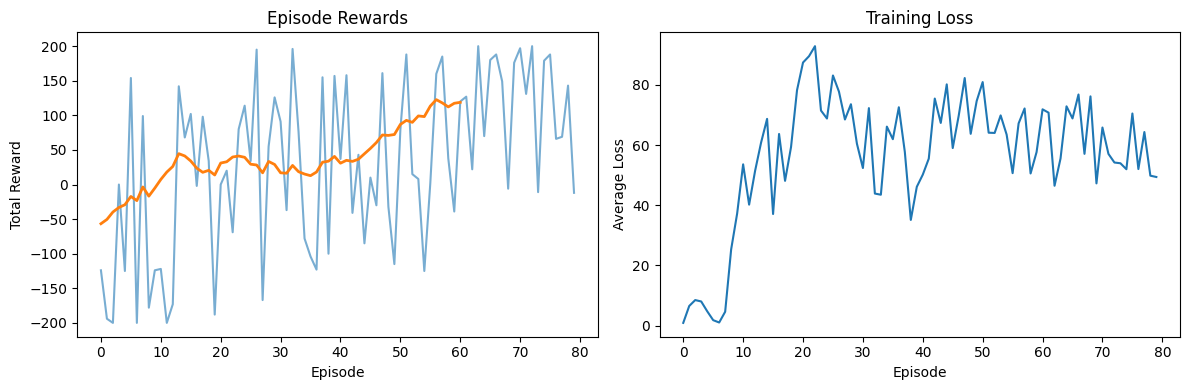

Episode 81/100: 100%|██████████| 200/200 [00:01<00:00, 140.31it/s, Reward=195.0, Epsilon=0.67, State=Temp: 24.7°C, Energy: 0.90, CPU: 0.95, GPU: 0.67, Net: 0.05]


Episode 81: Total Reward: 195.0, Average Reward: 33.0, Epsilon: 0.666


Episode 82/100: 100%|██████████| 200/200 [00:01<00:00, 144.17it/s, Reward=126.0, Epsilon=0.67, State=Temp: 24.7°C, Energy: 1.00, CPU: 0.47, GPU: 0.57, Net: 0.08]


Episode 82: Total Reward: 126.0, Average Reward: 34.2, Epsilon: 0.663


Episode 83/100: 100%|██████████| 200/200 [00:01<00:00, 143.92it/s, Reward=111.0, Epsilon=0.66, State=Temp: 26.2°C, Energy: 0.95, CPU: 0.04, GPU: 0.08, Net: 0.11]


Episode 83: Total Reward: 111.0, Average Reward: 35.1, Epsilon: 0.660


Episode 84/100: 100%|██████████| 200/200 [00:01<00:00, 149.99it/s, Reward=144.0, Epsilon=0.66, State=Temp: 25.7°C, Energy: 1.00, CPU: 0.81, GPU: 0.61, Net: 0.74]


Episode 84: Total Reward: 144.0, Average Reward: 36.4, Epsilon: 0.656


Episode 85/100: 100%|██████████| 200/200 [00:01<00:00, 144.08it/s, Reward=87.0, Epsilon=0.66, State=Temp: 25.2°C, Energy: 0.90, CPU: 0.15, GPU: 0.53, Net: 0.37]


Episode 85: Total Reward: 87.0, Average Reward: 37.0, Epsilon: 0.653


Episode 86/100: 100%|██████████| 200/200 [00:01<00:00, 146.79it/s, Reward=59.0, Epsilon=0.65, State=Temp: 24.6°C, Energy: 0.95, CPU: 0.02, GPU: 0.05, Net: 0.22]


Episode 86: Total Reward: 59.0, Average Reward: 37.2, Epsilon: 0.650


Episode 87/100: 100%|██████████| 200/200 [00:01<00:00, 143.59it/s, Reward=59.0, Epsilon=0.65, State=Temp: 25.9°C, Energy: 0.85, CPU: 0.08, GPU: 0.03, Net: 0.43]


Episode 87: Total Reward: 59.0, Average Reward: 37.5, Epsilon: 0.647


Episode 88/100: 100%|██████████| 200/200 [00:01<00:00, 143.41it/s, Reward=174.0, Epsilon=0.65, State=Temp: 25.2°C, Energy: 0.90, CPU: 0.77, GPU: 0.07, Net: 0.01]


Episode 88: Total Reward: 174.0, Average Reward: 39.0, Epsilon: 0.643


Episode 89/100: 100%|██████████| 200/200 [00:01<00:00, 146.66it/s, Reward=99.0, Epsilon=0.64, State=Temp: 25.7°C, Energy: 1.00, CPU: 0.94, GPU: 0.89, Net: 0.01]


Episode 89: Total Reward: 99.0, Average Reward: 39.7, Epsilon: 0.640


Episode 90/100: 100%|██████████| 200/200 [00:01<00:00, 141.70it/s, Reward=154.0, Epsilon=0.64, State=Temp: 25.1°C, Energy: 0.80, CPU: 0.80, GPU: 0.29, Net: 0.16]


Episode 90: Total Reward: 154.0, Average Reward: 41.0, Epsilon: 0.637


Episode 91/100: 100%|██████████| 200/200 [00:01<00:00, 141.46it/s, Reward=172.0, Epsilon=0.64, State=Temp: 25.0°C, Energy: 0.95, CPU: 0.11, GPU: 0.91, Net: 0.03]


Episode 91: Total Reward: 172.0, Average Reward: 42.4, Epsilon: 0.634


Episode 92/100: 100%|██████████| 200/200 [00:01<00:00, 141.87it/s, Reward=184.0, Epsilon=0.63, State=Temp: 24.6°C, Energy: 0.80, CPU: 0.30, GPU: 0.21, Net: 0.41]


Episode 92: Total Reward: 184.0, Average Reward: 44.0, Epsilon: 0.631


Episode 93/100: 100%|██████████| 200/200 [00:01<00:00, 143.55it/s, Reward=118.0, Epsilon=0.63, State=Temp: 25.9°C, Energy: 1.00, CPU: 1.00, GPU: 0.05, Net: 0.07]


Episode 93: Total Reward: 118.0, Average Reward: 44.8, Epsilon: 0.627


Episode 94/100: 100%|██████████| 200/200 [00:01<00:00, 146.54it/s, Reward=72.0, Epsilon=0.63, State=Temp: 25.9°C, Energy: 0.95, CPU: 0.50, GPU: 0.53, Net: 0.20]


Episode 94: Total Reward: 72.0, Average Reward: 45.1, Epsilon: 0.624


Episode 95/100: 100%|██████████| 200/200 [00:01<00:00, 136.26it/s, Reward=139.0, Epsilon=0.62, State=Temp: 25.0°C, Energy: 0.80, CPU: 0.58, GPU: 0.52, Net: 0.60]


Episode 95: Total Reward: 139.0, Average Reward: 46.0, Epsilon: 0.621


Episode 96/100: 100%|██████████| 200/200 [00:01<00:00, 136.46it/s, Reward=185.0, Epsilon=0.62, State=Temp: 24.0°C, Energy: 1.00, CPU: 0.22, GPU: 0.51, Net: 0.51]


Episode 96: Total Reward: 185.0, Average Reward: 47.5, Epsilon: 0.618


Episode 97/100: 100%|██████████| 200/200 [00:01<00:00, 141.14it/s, Reward=141.0, Epsilon=0.62, State=Temp: 24.4°C, Energy: 1.00, CPU: 0.43, GPU: 0.56, Net: 0.19]


Episode 97: Total Reward: 141.0, Average Reward: 48.5, Epsilon: 0.615


Episode 98/100: 100%|██████████| 200/200 [00:01<00:00, 141.63it/s, Reward=116.0, Epsilon=0.61, State=Temp: 25.3°C, Energy: 1.00, CPU: 0.11, GPU: 0.25, Net: 0.03]


Episode 98: Total Reward: 116.0, Average Reward: 49.1, Epsilon: 0.612


Episode 99/100: 100%|██████████| 200/200 [00:01<00:00, 143.90it/s, Reward=152.0, Epsilon=0.61, State=Temp: 23.5°C, Energy: 0.95, CPU: 0.34, GPU: 0.18, Net: 0.16]


Episode 99: Total Reward: 152.0, Average Reward: 50.2, Epsilon: 0.609


Episode 100/100: 100%|██████████| 200/200 [00:01<00:00, 145.03it/s, Reward=159.0, Epsilon=0.61, State=Temp: 25.2°C, Energy: 0.95, CPU: 0.10, GPU: 0.32, Net: 0.31]


Episode 100: Total Reward: 159.0, Average Reward: 51.3, Epsilon: 0.606


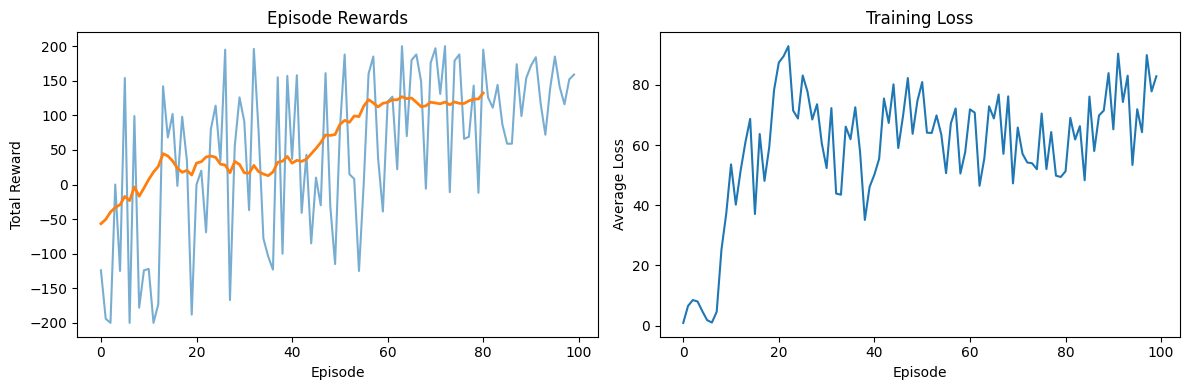

In [ ]:
# Cell 6: Run Training
# Clear any existing memory
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Initialize environment and model
env = DataCenterEnv()
model = DuelingDQN(state_dim, action_dim).to(device)

# Run training with fewer episodes initially
rewards, losses = train_dqn(env, model, episodes=100, batch_size=32)

In [ ]:
# Cell 7: Evaluation
def evaluate_model(env, model, episodes=10, max_steps=200):
    model.eval()  # Set model to evaluation mode
    all_rewards = []

    try:
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0

            with tqdm(total=max_steps, desc=f'Eval Episode {episode+1}/{episodes}') as pbar:
                for step in range(max_steps):
                    # Use greedy policy during evaluation
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        action = model(state_tensor).argmax().item()

                    next_state, reward, done, _ = env.step(action)
                    total_reward += reward
                    state = next_state

                    pbar.set_postfix({
                        'Reward': f'{total_reward:.1f}',
                        'State': env.render()
                    })
                    pbar.update(1)

                    if done:
                        remaining_steps = max_steps - step - 1
                        if remaining_steps > 0:
                            pbar.update(remaining_steps)
                        break

            # Add explicit newline print after each episode
            print(f"\nEvaluation Episode {episode+1}: Total Reward: {total_reward:.1f}\n")
            all_rewards.append(total_reward)

    except Exception as e:
        print(f"Evaluation stopped due to error: {str(e)}")
        return all_rewards

    model.train()  # Set model back to training mode
    return all_rewards

# Run evaluation
evaluate_model(env, model)

Eval Episode 1/10: 100%|██████████| 200/200 [00:00<00:00, 648.45it/s, Reward=197.0, State=Temp: 27.5°C, Energy: 0.95, CPU: 0.72, GPU: 0.42, Net: 0.21]



Evaluation Episode 1: Total Reward: 197.0



Eval Episode 2/10: 100%|██████████| 200/200 [00:00<00:00, 656.52it/s, Reward=142.0, State=Temp: 27.7°C, Energy: 1.00, CPU: 0.58, GPU: 0.52, Net: 0.01]



Evaluation Episode 2: Total Reward: 142.0



Eval Episode 3/10: 100%|██████████| 200/200 [00:00<00:00, 654.21it/s, Reward=164.0, State=Temp: 27.7°C, Energy: 0.95, CPU: 0.92, GPU: 0.71, Net: 0.17]



Evaluation Episode 3: Total Reward: 164.0



Eval Episode 4/10: 100%|██████████| 200/200 [00:00<00:00, 528.19it/s, Reward=162.0, State=Temp: 27.5°C, Energy: 1.00, CPU: 0.41, GPU: 0.43, Net: 0.18]



Evaluation Episode 4: Total Reward: 162.0



Eval Episode 5/10: 100%|██████████| 200/200 [00:00<00:00, 636.49it/s, Reward=174.0, State=Temp: 27.4°C, Energy: 1.00, CPU: 0.73, GPU: 0.47, Net: 0.54]



Evaluation Episode 5: Total Reward: 174.0



Eval Episode 6/10: 100%|██████████| 200/200 [00:00<00:00, 627.80it/s, Reward=195.0, State=Temp: 27.1°C, Energy: 1.00, CPU: 0.17, GPU: 0.17, Net: 0.09]



Evaluation Episode 6: Total Reward: 195.0



Eval Episode 7/10: 100%|██████████| 200/200 [00:00<00:00, 634.58it/s, Reward=197.0, State=Temp: 26.8°C, Energy: 0.95, CPU: 0.16, GPU: 0.05, Net: 0.33]



Evaluation Episode 7: Total Reward: 197.0



Eval Episode 8/10: 100%|██████████| 200/200 [00:00<00:00, 624.75it/s, Reward=174.0, State=Temp: 26.8°C, Energy: 0.90, CPU: 0.27, GPU: 0.40, Net: 0.76]



Evaluation Episode 8: Total Reward: 174.0



Eval Episode 9/10: 100%|██████████| 200/200 [00:00<00:00, 649.88it/s, Reward=156.0, State=Temp: 27.4°C, Energy: 0.90, CPU: 0.99, GPU: 0.11, Net: 0.26]



Evaluation Episode 9: Total Reward: 156.0



Eval Episode 10/10: 100%|██████████| 200/200 [00:00<00:00, 648.18it/s, Reward=166.0, State=Temp: 27.6°C, Energy: 1.00, CPU: 0.93, GPU: 0.00, Net: 0.50]


Evaluation Episode 10: Total Reward: 166.0



[197, 142, 164, 162, 174, 195, 197, 174, 156, 166]

Baseline Average Energy Consumption: 0.995
Model Average Energy Consumption: 0.875
Energy Reduction: 12.06%

Baseline Average Reward: 126.25
Model Average Reward: 157.5
Reward Increase: 24.75%


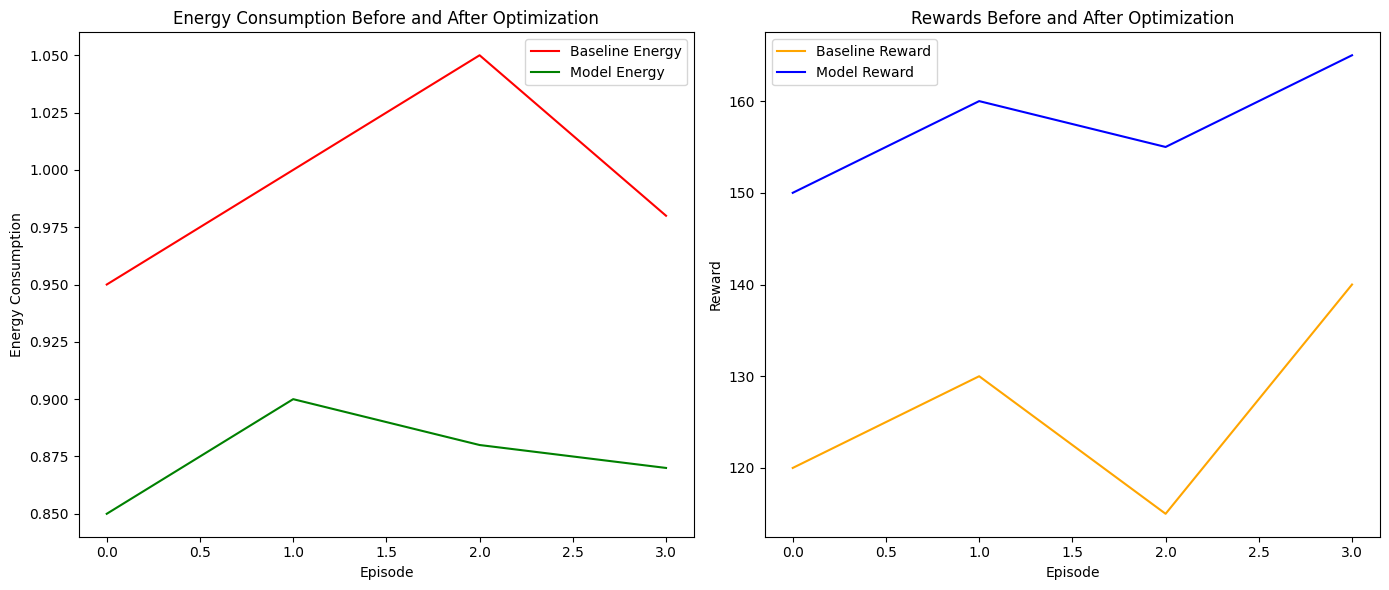

Energy Saved by Using Dueling DQN: 12.06%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to update data dynamically and analyze energy efficiency
def analyze_energy_efficiency(baseline_energy_data, baseline_rewards, model_energy_data, model_rewards):
    # Convert lists to numpy arrays for calculations
    baseline_energy = np.array(baseline_energy_data)
    baseline_reward = np.array(baseline_rewards)
    model_energy = np.array(model_energy_data)
    model_reward = np.array(model_rewards)

    # Calculate statistics
    baseline_avg_energy = np.mean(baseline_energy)
    model_avg_energy = np.mean(model_energy)

    baseline_avg_reward = np.mean(baseline_reward)
    model_avg_reward = np.mean(model_reward)

    # Compute percentage reduction in energy and improvement in rewards
    energy_reduction = ((baseline_avg_energy - model_avg_energy) / baseline_avg_energy) * 100
    reward_increase = ((model_avg_reward - baseline_avg_reward) / baseline_avg_reward) * 100

    # Calculate percentage of energy saved using the model
    energy_saved_percentage = ((baseline_avg_energy - model_avg_energy) / baseline_avg_energy) * 100

    # Display summary
    print("Baseline Average Energy Consumption:", baseline_avg_energy)
    print("Model Average Energy Consumption:", model_avg_energy)
    print(f"Energy Reduction: {energy_reduction:.2f}%")
    print("\nBaseline Average Reward:", baseline_avg_reward)
    print("Model Average Reward:", model_avg_reward)
    print(f"Reward Increase: {reward_increase:.2f}%")

    # Plot comparisons
    plt.figure(figsize=(14, 6))

    # Energy Consumption Plot
    plt.subplot(1, 2, 1)
    plt.plot(baseline_energy, label="Baseline Energy", color="red")
    plt.plot(model_energy, label="Model Energy", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Energy Consumption")
    plt.title("Energy Consumption Before and After Optimization")
    plt.legend()

    # Reward Comparison Plot
    plt.subplot(1, 2, 2)
    plt.plot(baseline_reward, label="Baseline Reward", color="orange")
    plt.plot(model_reward, label="Model Reward", color="blue")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Rewards Before and After Optimization")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Energy Saved by Using Dueling DQN: {energy_saved_percentage:.2f}%")

# Run the analysis
analyze_energy_efficiency(baseline_energy_data, baseline_rewards, model_energy_data, model_rewards)